# Silver Evaluation

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import copy

from memolon.src import utils, constants

In [2]:
utils.language_table.head()

,fastText_fullname,google_fullname,google_iso,articles_wiki
iso,,,,
af,Afrikaans,afrikaans,af,85954
sq,Albanian,albanian,sq,77869
am,Amharic,amharic,am,14849
ar,Arabic,arabic,ar,964345
hy,Armenian,armenian,hy,259237


Define silver evaluation for a single language:

In [3]:
def silver_eval_one_lang(targetMT, targetPred):
    
    rt = {}
    
    # Intersect targetMT and targetPred. Note that targetMT may have duplicated entries, but not targetPred
    overlap = utils.list_intersection(targetMT.index, targetPred.index)
    targetMT = targetMT.loc[overlap]
    # targetMT.index includes duplicates, the next line makes sure, that both DataFrames have equal length
    targetPred = targetPred.loc[targetMT.index] 
    
    for emo in constants.emotions:
        rt[emo] = st.pearsonr(targetMT[emo], targetPred[emo])[0]
        
    return rt
    

Define silver evaluation for all languages:

In [4]:
def silver_evaluation_all_langs(split, version):
    df = pd.DataFrame(index=utils.language_table.index, columns=constants.emotions, data=0.)
    for iso in utils.language_table.index:
        print(iso, end='\r')
        rt = silver_eval_one_lang(targetMT=utils.get_TargetMT(iso=iso, split=split),
                             targetPred=utils.get_TargetPred(iso=iso, split=split, version=version))
        df.loc[iso] = rt
    return df

## Development Experiment on Multi-Task-Learning Strategy

In [5]:
versions = ['grouped', 'stl', 'mtl', 'vad_mtl_be5_stl', 'vad_stl_be5_mtl']
df = pd.DataFrame(index=pd.MultiIndex.from_product([versions, utils.language_table.index], names=['version', 'iso']),
                  columns=constants.emotions, 
                  data=0.)
for v in versions:
    print(v)
    rt = silver_evaluation_all_langs(split='dev', version=v)
    for l in rt.index:
        df.loc[(v,l)] = rt.loc[l]
    
df.to_csv(constants.DEV_EXPERIMENT_RESULTS)

grouped


<ipython-input-5-8319f9a597f6>:7: DtypeWarning: Columns (57) have mixed types.Specify dtype option on import or set low_memory=False.
  rt = silver_evaluation_all_langs(split='dev', version=v)


stl
mtl
vad_mtl_be5_stl
vad_stl_be5_mtl


Loading and inspecting results:

In [6]:
df = pd.read_csv(constants.DEV_EXPERIMENT_RESULTS, index_col=[0,1])
df

valence   arousal  dominance       joy     anger  \
version         iso                                                      
grouped         af   0.609110  0.486365   0.517851  0.553323  0.584504   
                sq   0.630990  0.481044   0.540608  0.564867  0.648656   
                am   0.411797  0.244391   0.365238  0.350095  0.404305   
                ar   0.664606  0.490296   0.559575  0.575111  0.623923   
                hy   0.629570  0.516185   0.552495  0.567697  0.614802   
...                       ...       ...        ...       ...       ...   
vad_stl_be5_mtl vi   0.537049  0.413039   0.402302  0.480325  0.555454   
                cy   0.584975  0.395176   0.492637  0.553074  0.547263   
                fy   0.423755  0.297674   0.357757  0.396400  0.412388   
                yi   0.370938  0.241268   0.305170  0.321105  0.385725   
                yo   0.188441  0.119104   0.143807  0.231082  0.161925   

                      sadness      fear   disgust  
version         iso                                
grouped         af   0.587339  0.583824  0.509445  
                sq   0.626285  0.640006  0.555325  
                am   0.387423  0.375810  0.310775  
                ar   0.630843  0.614889  0.596108  
                hy   0.586886  0.593994  0.538143  
...                       ...       ...       ...  
vad_stl_be5_mtl vi   0.511126  0.489371  0.522426  
                cy   0.555737  0.527687  0.529706  
                fy   0.398888  0.426071  0.353875  
                yi   0.380928  0.373594  0.343596  
                yo   0.174500  0.170530  0.167653  

[455 rows x 8 columns]

In [7]:
table = pd.DataFrame(index=versions, columns=constants.emotions, data=0.)
for v in versions:
    table.loc[v] = df.xs(v, level='version').mean()

table["mean"] = table.mean(axis=1)  
table["mean_vad"] = table[constants.vad].mean(axis=1)
table["mean_be5"] = table[constants.be5].mean(axis=1)
table = table.sort_values("mean", ascending=False)
table

,valence,arousal,dominance,joy,anger,sadness,fear,disgust,mean,mean_vad,mean_be5
mtl,0.569105,0.415168,0.483235,0.513926,0.562440,0.543606,0.543058,0.501057,0.516449,0.489169,0.532817
grouped,0.568447,0.419245,0.484302,0.504258,0.546825,0.530259,0.523064,0.496731,0.509141,0.490665,0.520227
vad_stl_be5_mtl,0.554000,0.399028,0.459571,0.504258,0.546825,0.530259,0.523064,0.496731,0.501717,0.470866,0.520227
vad_mtl_be5_stl,0.568447,0.419245,0.484302,0.482626,0.534835,0.509868,0.506203,0.474741,0.497534,0.490665,0.501655
stl,0.554000,0.399028,0.459571,0.482626,0.534835,0.509868,0.506203,0.474741,0.490109,0.470866,0.501655


`mtl` is slightly better across all variables than `grouped`. However the outcome is somewhat inconsistent: while `mtl` improves BE5 variables it actually leads to a performance drop for VAD.

---

## Actual Silver Evaluation

Run silver evaluation for all languages and save results to disk:

In [8]:
df = silver_evaluation_all_langs(split="test", version="grouped")
df.to_csv(constants.SILVER_EVALUATION_RESULTS)

<ipython-input-8-3ad3e1f69fae>:1: DtypeWarning: Columns (57) have mixed types.Specify dtype option on import or set low_memory=False.
  df = silver_evaluation_all_langs(split="test", version="grouped")


Load data and do further analysis and visualization:

In [9]:
df = pd.read_csv(constants.SILVER_EVALUATION_RESULTS, index_col=0)
df['mean'] = df.mean(axis=1)
df = df.sort_values('mean', ascending=False)
df.head()

,valence,arousal,dominance,joy,anger,sadness,fear,disgust,mean
iso,,,,,,,,,
en,0.940544,0.760695,0.878971,0.899509,0.914493,0.898406,0.885684,0.886774,0.883135
es,0.885645,0.702342,0.799313,0.829791,0.855900,0.846056,0.818424,0.810328,0.818475
it,0.878417,0.691315,0.809640,0.817006,0.854309,0.835281,0.821952,0.810328,0.814781
de,0.889465,0.657395,0.814296,0.823673,0.842842,0.818665,0.804190,0.814743,0.808159
sv,0.871370,0.641863,0.797535,0.817029,0.840017,0.815071,0.807747,0.797967,0.798575


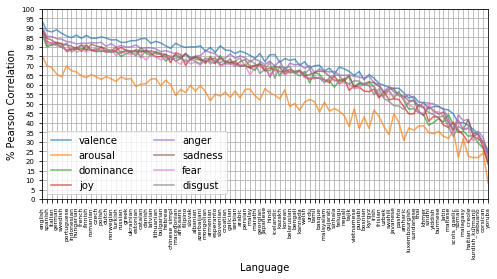

In [11]:
df['pos'] = list(range(1, len(df)+1))


fig, ax = plt.subplots(figsize=(8, 3.5))

ax.set_xlim([1,91])
ax.set_ylim([.0,1.0])

ax.set_xticklabels([utils.language_table.loc[x,'google_fullname'] for x in df.index],  rotation=90)
ax.set_xticks(df.pos)

ax.set_yticks(np.arange(start=.0, stop=1.01, step=.05))

ax.set_yticklabels(np.arange(start=0, stop=101, step=5))

ax.tick_params(axis='x', which='major', labelsize=6)
ax.tick_params(axis='y', which='major', labelsize=7)
ax.set_ylabel('% Pearson Correlation')
ax.set_xlabel('Language')

for d in ['valence', 'arousal', 'dominance', 'joy', 'anger', 'sadness', 'fear', 'disgust']:
    plt.plot(df.pos,df[d], label=d, alpha=.7)

plt.legend(ncol=2)
plt.grid()
fig.savefig('silver-line.png', dpi=300, bbox_inches = 'tight')

How many languages lie above certain performance thresholds?

In [12]:
len(df[df.valence > .70])

56

In [13]:
len(df[df.arousal > .5])

55

---
## Comparison against Baseline

Run silver evaluation for the baseline lexicons and save to disk:

In [14]:
df = silver_evaluation_all_langs(split="test", version="ridge")
df.to_csv(constants.BASELINE_RESULTS)

<ipython-input-14-ce16e5d1b59e>:1: DtypeWarning: Columns (57) have mixed types.Specify dtype option on import or set low_memory=False.
  df = silver_evaluation_all_langs(split="test", version="ridge")


Load ridge baseline and MTLFFN results and compare both:

In [15]:
mtlffn = pd.read_csv(constants.SILVER_EVALUATION_RESULTS, index_col=0)
mtlffn.head()

,valence,arousal,dominance,joy,anger,sadness,fear,disgust
iso,,,,,,,,
af,0.804851,0.575980,0.740162,0.759676,0.747276,0.736776,0.708647,0.743772
sq,0.799467,0.567820,0.734991,0.746040,0.752304,0.749164,0.719019,0.722643
am,0.558573,0.307365,0.518451,0.484960,0.531145,0.542322,0.524378,0.470908
ar,0.777428,0.531497,0.696889,0.700904,0.752839,0.722357,0.705438,0.741181
hy,0.796443,0.517502,0.721456,0.748405,0.769858,0.733432,0.708661,0.734218


In [16]:
ridge = pd.read_csv(constants.BASELINE_RESULTS, index_col=0)
ridge.head()

,valence,arousal,dominance,joy,anger,sadness,fear,disgust
iso,,,,,,,,
af,0.685140,0.502890,0.618513,0.667221,0.672090,0.630307,0.633227,0.614824
sq,0.696658,0.489099,0.616195,0.669951,0.657639,0.643525,0.625262,0.626086
am,0.503669,0.313524,0.465162,0.458828,0.490968,0.484878,0.471503,0.420737
ar,0.712092,0.484056,0.645098,0.669469,0.679765,0.667195,0.650396,0.678021
hy,0.694929,0.532108,0.644896,0.658505,0.690303,0.632257,0.646179,0.614042


In [17]:
diff = mtlffn - ridge 
diff.describe()

,valence,arousal,dominance,joy,anger,sadness,fear,disgust
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,0.079048,0.044693,0.073567,0.050656,0.070607,0.073825,0.063316,0.080315
std,0.023014,0.029422,0.024044,0.029991,0.024899,0.027044,0.024020,0.029668
min,0.012654,-0.051385,0.006968,-0.037028,0.006525,-0.002843,0.009986,-0.000513
25%,0.066861,0.026685,0.058593,0.032631,0.055238,0.057457,0.050633,0.062565
50%,0.081867,0.046591,0.075732,0.051788,0.072012,0.074670,0.062926,0.082428
75%,0.095777,0.063152,0.089937,0.074338,0.084210,0.091564,0.078353,0.096107
max,0.131455,0.114984,0.123476,0.106651,0.155728,0.148304,0.124651,0.185214


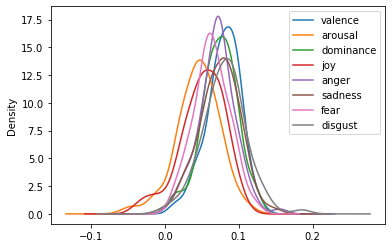

In [18]:
diff.plot.density()

In [19]:
baseline_wins = []
for l in diff.index:
    for e in diff.columns:
        entry = diff.loc[l, e]
        if entry < 0:
            baseline_wins.append((l,e,entry))

print(*baseline_wins, sep='\n')

('am', 'arousal', -0.006159210497008183)
('hy', 'arousal', -0.0146062336094811)
('co', 'joy', -0.026389372821373158)
('ka', 'arousal', -0.0141379818532541)
('ky', 'arousal', -0.0033653916265238837)
('la', 'joy', -0.012489045567706303)
('mt', 'joy', -0.037028015338405995)
('so', 'arousal', -0.03944609305908964)
('su', 'joy', -0.014647629655671845)
('su', 'sadness', -0.002843369431899667)
('vi', 'arousal', -0.013590984632543102)
('fy', 'joy', -0.011430884877390413)
('yo', 'arousal', -0.051385115633792805)
('yo', 'joy', -0.030942277982969058)
('yo', 'disgust', -0.0005132990816295036)


In [20]:
len(baseline_wins)

15

In [21]:
# all cases:
diff.shape[0] * diff.shape[1]

728

In [22]:
len(baseline_wins) / (diff.shape[0] * diff.shape[1])

0.020604395604395604

In [23]:
utils.language_table.loc[["am", "hy", "co", "ka", "ky", "la", "mt", "so", "su", "vi", "fy", "yo"]]

,fastText_fullname,google_fullname,google_iso,articles_wiki
iso,,,,
am,Amharic,amharic,am,14849
hy,Armenian,armenian,hy,259237
co,Corsican,corsican,co,5689
ka,Georgian,georgian,ka,132233
ky,Kirghiz,kyrgyz,ky,79735
la,Latin,latin,la,131359
mt,Maltese,maltese,mt,3425
so,Somali,somali,so,5655
su,Sundanese,sundanese,su,59571


In [24]:
# mean difference to baseline over all languages and emotions
diff.mean().mean()

0.06700344635751967

In [25]:
# standard deviation over languages
diff.mean(axis=1).std()

0.02025543513760738

---

## Correlation of Silver Evaluation Results with Wikipedia Article Number

In [26]:
silver = pd.read_csv(constants.SILVER_EVALUATION_RESULTS, index_col=0)
silver["mean"] = silver.mean(axis=1)
silver.head()

,valence,arousal,dominance,joy,anger,sadness,fear,disgust,mean
iso,,,,,,,,,
af,0.804851,0.575980,0.740162,0.759676,0.747276,0.736776,0.708647,0.743772,0.727142
sq,0.799467,0.567820,0.734991,0.746040,0.752304,0.749164,0.719019,0.722643,0.723931
am,0.558573,0.307365,0.518451,0.484960,0.531145,0.542322,0.524378,0.470908,0.492263
ar,0.777428,0.531497,0.696889,0.700904,0.752839,0.722357,0.705438,0.741181,0.703567
hy,0.796443,0.517502,0.721456,0.748405,0.769858,0.733432,0.708661,0.734218,0.716247


In [27]:
lgs = utils.language_table
lgs.head()

,fastText_fullname,google_fullname,google_iso,articles_wiki
iso,,,,
af,Afrikaans,afrikaans,af,85954
sq,Albanian,albanian,sq,77869
am,Amharic,amharic,am,14849
ar,Arabic,arabic,ar,964345
hy,Armenian,armenian,hy,259237


In [28]:
st.spearmanr(silver["mean"], lgs["articles_wiki"])

SpearmanrResult(correlation=0.7333811116419812, pvalue=1.3791652435925386e-16)

---